# Algorithmic Trading COMP0051 2023/24 Coursework 2

#### 1. Time Series Prep [30 Points]

### (a)

In [13]:
import pandas as pd

# Load the data
sptl_df = pd.read_csv('SPTL.csv')
effr_df = pd.read_excel('EFFR_rates.xlsx')

# Convert EFFR annual rate to a daily rate assuming 252 trading days in a year
effr_df['Daily Rate'] = effr_df['Rate (%)'] / 100 / 252

# Process dates for merging
effr_df['Effective Date'] = pd.to_datetime(effr_df['Effective Date'])
effr_df.set_index('Effective Date', inplace=True)
sptl_df['Date'] = pd.to_datetime(sptl_df['Date'])
sptl_df.set_index('Date', inplace=True)

# Merge the datasets on the date index
merged_df = sptl_df.join(effr_df['Daily Rate'], how='left')
merged_df['Daily Rate'].fillna(method='ffill', inplace=True)

# Calculate the daily price change for SPTL
merged_df['Price Change'] = merged_df['Adj Close'].diff()

# Calculate the daily excess return per unit of SPTL
merged_df['Excess Return'] = merged_df['Price Change'] / merged_df['Adj Close'] - merged_df['Daily Rate']

merged_df.head(5)


c:\Users\lyakh\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\lyakh\AppData\Local\Temp\ipykernel_28852\710385673.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['Daily Rate'].fillna(method='ffill', inplace=True)


,Open,High,Low,Close,Adj Close,Volume,Daily Rate,Price Change,Excess Return
Date,,,,,,,,,
2014-01-02,29.924999,30.070000,29.924999,30.055,23.299057,25400,0.000003,NaN,NaN
2014-01-03,29.959999,30.105000,29.959999,30.035,23.283548,22000,0.000003,-0.015509,-0.000669
2014-01-06,30.110001,30.270000,30.110001,30.160,23.380453,3200,0.000003,0.096905,0.004142
2014-01-07,30.240000,30.260000,30.200001,30.260,23.457968,3800,0.000003,0.077515,0.003302
2014-01-08,30.075001,30.184999,30.075001,30.150,23.372698,14800,0.000003,-0.085270,-0.003651


### (b)

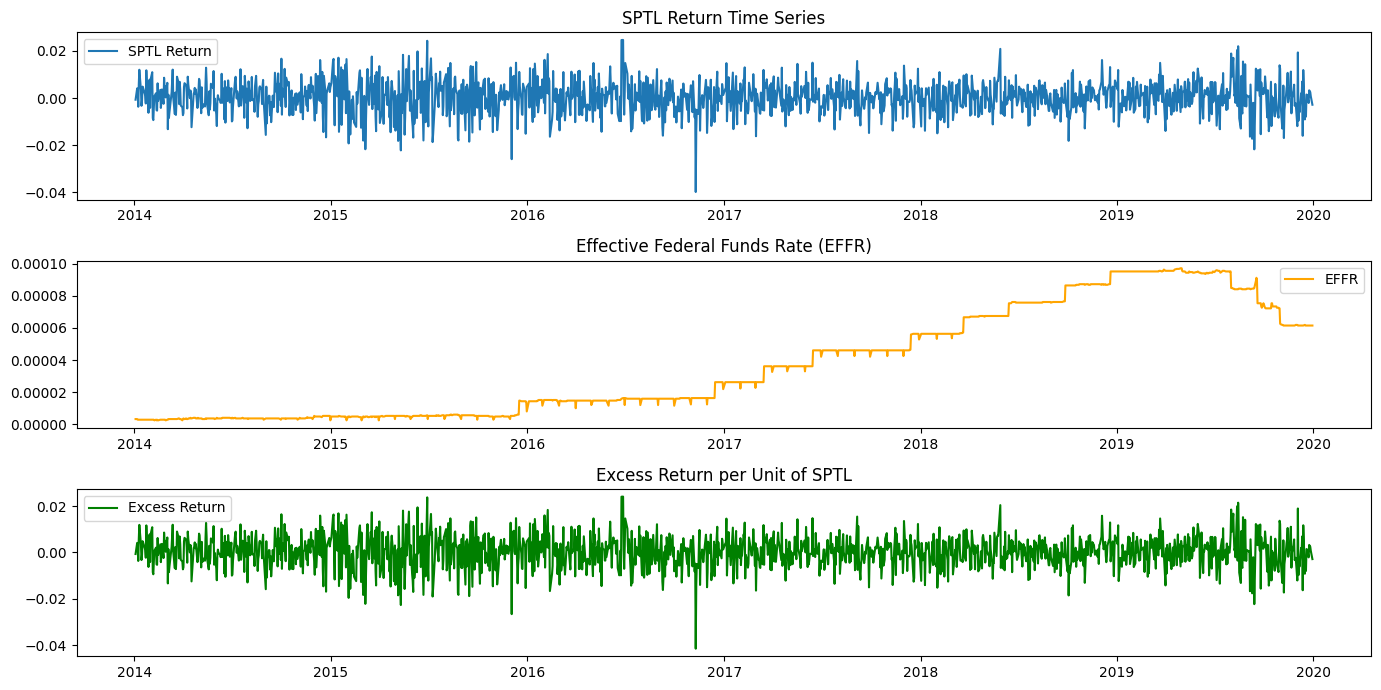

In [14]:
import matplotlib.pyplot as plt

# Calculate the daily return for SPTL
merged_df['SPTL Return'] = merged_df['Adj Close'].pct_change()

# Remove the NaN values for plotting
plot_df = merged_df.dropna(subset=['SPTL Return', 'Daily Rate', 'Excess Return'])

# Plotting
plt.figure(figsize=(14, 7))

# SPTL return time series
plt.subplot(3, 1, 1)
plt.plot(plot_df.index, plot_df['SPTL Return'], label='SPTL Return')
plt.title('SPTL Return Time Series')
plt.legend()

# EFFR time series
plt.subplot(3, 1, 2)
plt.plot(plot_df.index, plot_df['Daily Rate'], label='EFFR', color='orange')
plt.title('Effective Federal Funds Rate (EFFR)')
plt.legend()

# Excess return per unit of SPTL
plt.subplot(3, 1, 3)
plt.plot(plot_df.index, plot_df['Excess Return'], label='Excess Return', color='green')
plt.title('Excess Return per Unit of SPTL')
plt.legend()

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


#### 2. Trading Strategies [45 Points]

### (a)

In [19]:
import numpy as np

# Define the initial capital and leverage
initial_capital = 200000
leverage = 10

# Calculate the number of days for the training set (70% of the data)
training_days = int(len(merged_df) * 0.7)

# Split the data into training and test sets
training_set = merged_df.iloc[:training_days].copy()
test_set = merged_df.iloc[training_days:].copy()

# print(training_set.head())
# print(test_set.head())

# Define the trading strategies
def trading_strategy_1(row, previous_return):
    return np.sign(previous_return) * initial_capital * leverage

def trading_strategy_2(row, previous_return):
    return -np.sign(previous_return) * initial_capital * leverage

def trading_strategy_3(row, previous_return):
    return np.random.choice([-1, 1]) * initial_capital * leverage

# Initialize previous return
previous_return = 0

# Calculate daily PnL for each strategy
for strategy_function in [trading_strategy_1, trading_strategy_2, trading_strategy_3]:
    book_size = []
    for index, row in test_set.iterrows():
        book_size.append(strategy_function(row, previous_return))
        previous_return = row['SPTL Return']

    test_set.loc[:, strategy_function.__name__ + ' Book Size'] = book_size
    test_set.loc[:, strategy_function.__name__ + ' PnL'] = (test_set['Price Change'] / test_set['Adj Close'] - test_set['Daily Rate']) * test_set[strategy_function.__name__ + ' Book Size']

# Print the test set with the new columns for book size and PnL of each strategy
print(test_set.head())

                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2018-03-14  34.410000  34.680000  34.410000  34.630001  29.946871   91300   
2018-03-15  34.619999  34.680000  34.560001  34.639999  29.955521   40200   
2018-03-16  34.520000  34.549999  34.439999  34.520000  29.851740   42000   
2018-03-19  34.369999  34.560001  34.330002  34.410000  29.756617   55000   
2018-03-20  34.230000  34.340000  34.230000  34.270000  29.635559   34500   

            Daily Rate  Price Change  Excess Return  SPTL Return  \
Date                                                               
2018-03-14    0.000056      0.233486       0.007740     0.007858   
2018-03-15    0.000057      0.008650       0.000232     0.000289   
2018-03-16    0.000057     -0.103781      -0.003533    -0.003465   
2018-03-19    0.000057     -0.095123      -0.003253    -0.003187   
2018-03-20    0.000057     -0.121058      -0.004142 

### (b)

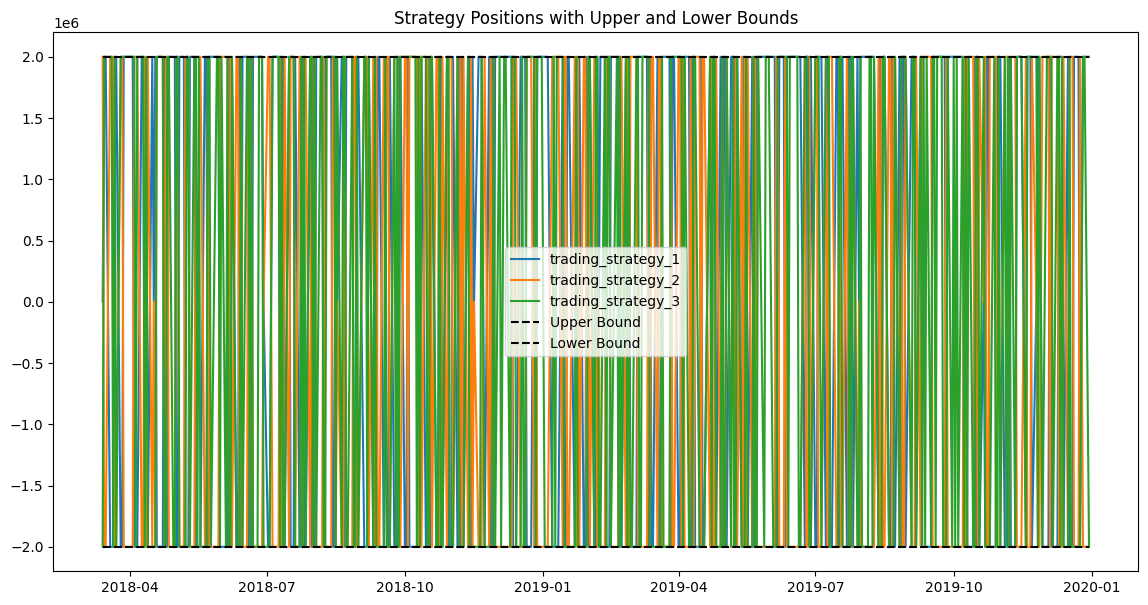

In [17]:
import matplotlib.pyplot as plt

# Assuming test_set DataFrame has the strategies' positions calculated as per previous steps
# Calculate the upper and lower bounds for each strategy
test_set['Upper Bound'] = initial_capital * leverage
test_set['Lower Bound'] = -initial_capital * leverage

# Initialize a figure
plt.figure(figsize=(14, 7))

# Plot the position of each strategy and the upper/lower bounds
for strategy_function in [trading_strategy_1, trading_strategy_2, trading_strategy_3]:
    strategy_name = strategy_function.__name__
    plt.plot(test_set.index, test_set[strategy_name + ' Book Size'], label=strategy_name)

# Plot the upper and lower bounds
plt.plot(test_set.index, test_set['Upper Bound'], label='Upper Bound', linestyle='--', color='k')
plt.plot(test_set.index, test_set['Lower Bound'], label='Lower Bound', linestyle='--', color='k')

plt.title('Strategy Positions with Upper and Lower Bounds')
plt.legend()
plt.show()
